In [145]:
import pandas as pd 
import datetime
import numpy as np 
import matplotlib.pyplot as plt 
import statsmodels.api as sm

from pylab import rcParams
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from sklearn.metrics import mean_squared_error
from math import sqrt
from scipy import stats

%matplotlib inline

**В Данном минипроекте исследуется Файл 'venezia.csv',  которые представлет из себя обычный (но достаточно большой) временной ряд  
Попытался найти интересные факты и зависимости к нем  
Все, что я делаю оформлено в виде комментариев дальше**

In [2]:
# Датасет взят с kaggle
filename = 'venezia.csv'

In [3]:
data = pd.read_csv(filename)

In [4]:
# Стандартно, чтобы понять о чем вообще этот датасет
# Датасет хранит данные по уровню воды в Венеции относительно какой-то стандартной точки
# Кажая запись - это один час, начиная с 1-января-1983 01:00:00 по 1-января-2016 00:00:00
# Всего 289272 часа => 12053 дня => 34 года
print('head:\n', data.head(3))
print('\ntail:\n', data.tail(2))
print('\ndescribe:\n', data.describe())
print('\nshape:', data.shape)

head:
               datetime  level
0  1983-01-01 01:00:00   44.0
1  1983-01-01 02:00:00   35.0
2  1983-01-01 03:00:00   23.0

tail:
                    datetime  level
289270  2015-12-31 23:00:00    8.0
289271  2016-01-01 00:00:00   20.0

describe:
                level
count  289272.000000
mean       25.883449
std        29.130133
min       -92.000000
25%         6.000000
50%        27.000000
75%        47.000000
max       159.000000

shape: (289272, 2)


In [161]:
# По сути вся преобработка, в таблице всего два столбца, так что больше ничего не нужно с:
data.reset_index(inplace=True)
data['datetime'] = pd.to_datetime(data['datetime'])
data = data.set_index('datetime')

In [162]:
levels = data.level
train = data.iloc[:-365 * 24]
test = data.iloc[-365 * 24:] # последний год (2015)

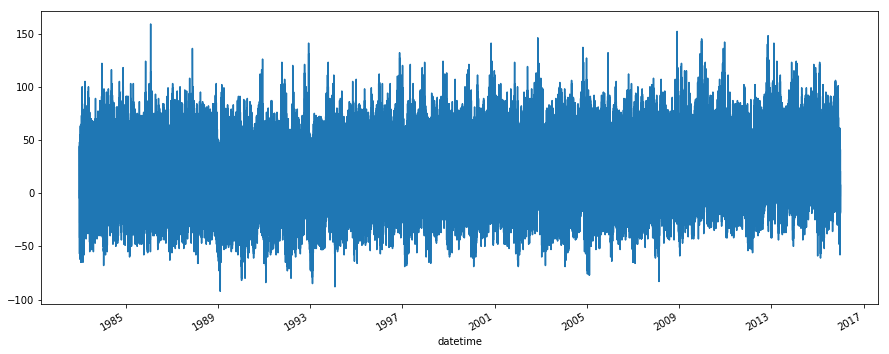

In [7]:
# Данных слишком много, чтобы можно было сделать какие-либо выводы так сразу
data.level.plot(figsize=(15,6))

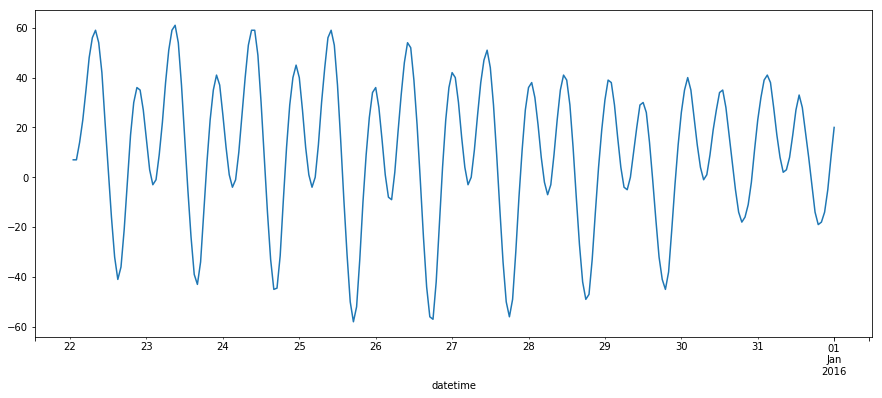

In [19]:
# Выведем последние 10 дней : 240 часов
# Хорошо видно наличие сезонности (причем с периодом примерно 24 часа)
# Более того, можно подумать и преположить что эта сезонность как-то связана с приливами и отливами
# Чуть позже мы это попытаемся проверить, а пока попробум лучше изучить датасет
data.level[-240:].plot(figsize=(15,6))

## Немного Про Приливы И Отливы  
***
- Луна над головой => Большая Приливная Волна  
- Луна под головой => Малая Приливная Волна (Я тоже удивлен)  
- Луна восходит или заходит => Отлив  
Период: 28 дней: БПВ - Отлив - МПВ - Отлив  
Солнце в противостоянии и в соединении с луной увелицивает прилив, а в квадратуре - уменьшает  
более подробно: https://ru.wikipedia.org/wiki/Прилив_и_отлив
***

[[ 1.         -0.09363219]
 [-0.09363219  1.        ]]


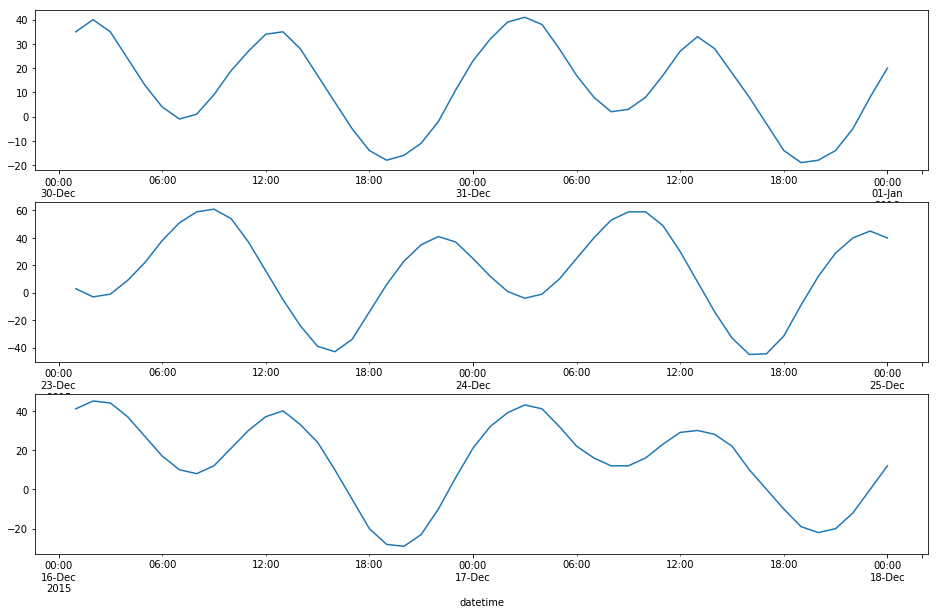

In [10]:
# Выведем данные двух дней для 30 Dec - 1 Jan, 23-25 Dec и 16-18 Dec (Разница - неделя)
# Видим, что второй граффик похож на -1 * первый граффик (Подтверждение: корреляция = -0.9)
# Значит, когда в первом граффике был прилив, во втором, в то же время - отлив
# Хорошо соответстует реальному пероду приливов и отливов
# Потому что луна как раз успеват переместиться на pi/2 за неделю
rcParams['figure.figsize'] = 16, 10
ax1 = plt.subplot(311)
test.level[-24 * 2:].plot()
ax2 = plt.subplot(312)
test.level[-24 * 9: -24 * 7].plot()
ax3 = plt.subplot(313)
test.level[-24 * 16: -24 * 14].plot()
print(np.corrcoef(test.level[-24 * 2:], test.level[-24 * 9: -24 * 7]))

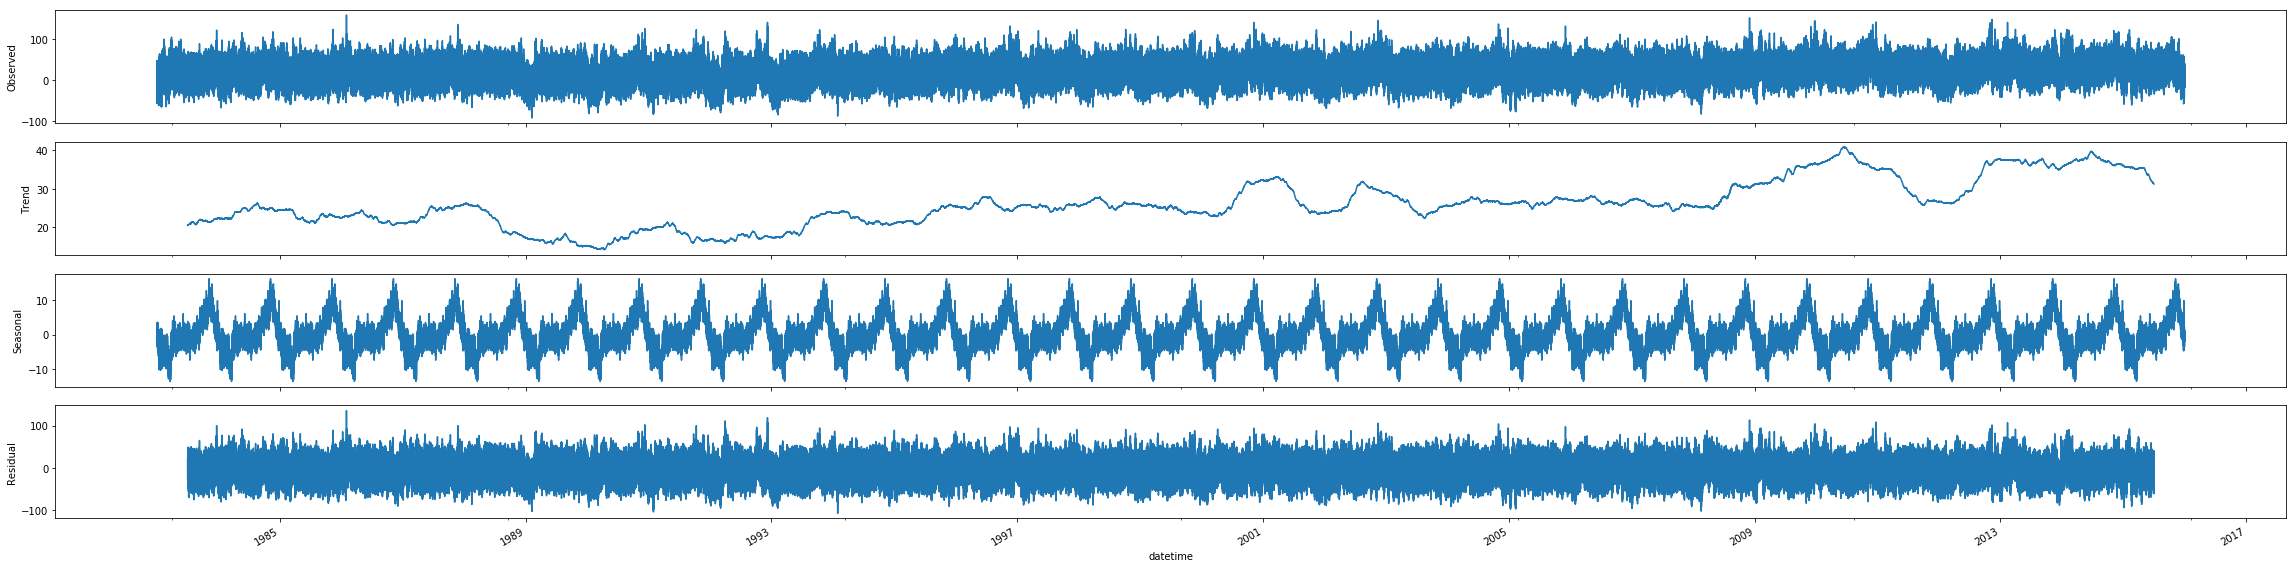

In [15]:
# Построим STL-декомпозицию с частотой раной примерно одному году (13 лунных месяцев)
# Тоже видна какая-то сезонность, видимо связанная с тем, что весой снег тает и воды,
# обычно, больше, чем зимой, когда она может замерзнуть
rcParams['figure.figsize'] = 32, 8
stl_dec_year = sm.tsa.seasonal_decompose(data.level, freq=24*365+6).plot()

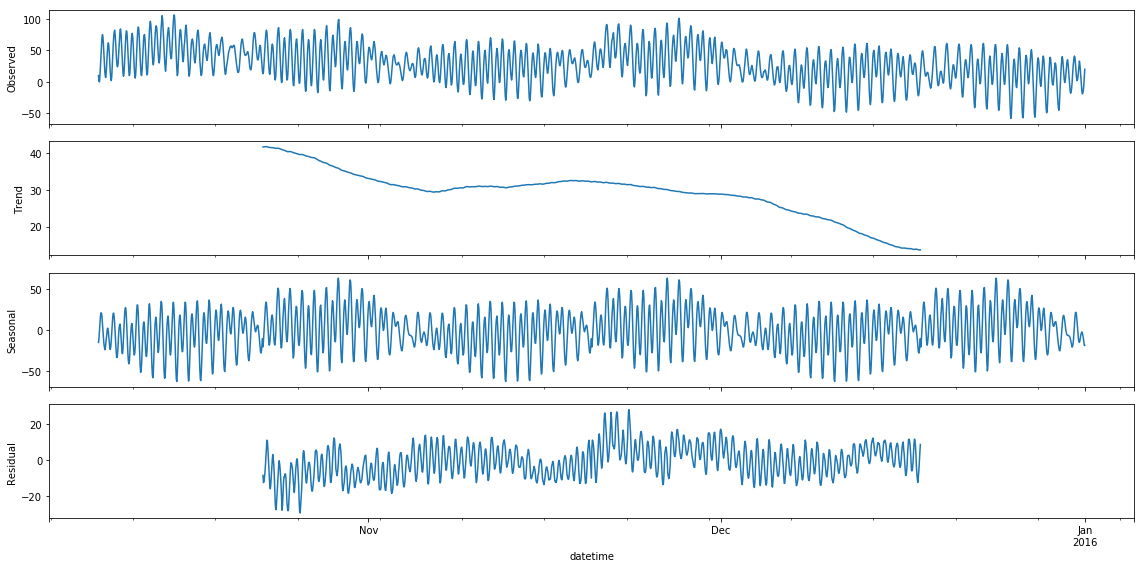

In [17]:
# Посмотрим на STL-декомпозицию ряда за последние 3 Лунных месяца 
# (C частотой, равной Лунному месяцу). ! И Внимательно Посмотрим На Сезонность !
# Видно, что каждый месяц можно разбить на два периода,
# Когда Вода поднимается чуть выше и чуть ниже - это как раз влияние Солнца
rcParams['figure.figsize'] = 16, 8
stl_sub_dec = sm.tsa.seasonal_decompose(data.level[-24*28*3:], freq=24 * 28)
stl_sub_dec.plot()
plt.show()

In [40]:
# И тут я осознал, что датасет намного сложнее, чем я думал
# Потому что есть отдельные сезонности по дням, месяцам и годам

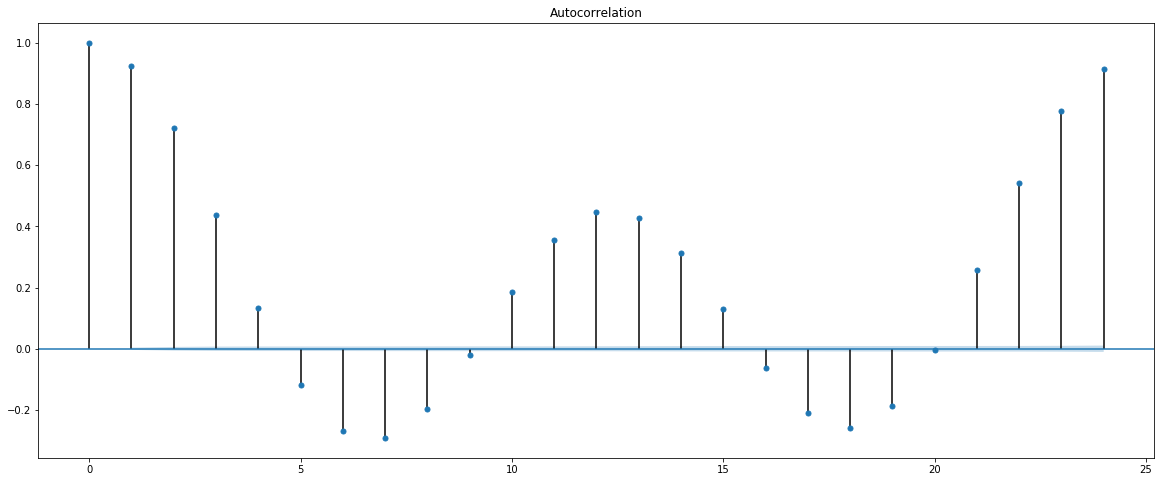

In [31]:
# Вот здесь очень хоршо видно в течение дня Большой, Малый приливы и Отливы
fig, ax = plt.subplots(figsize=(20,8))
sm.graphics.tsa.plot_acf(data.level.values, lags=24, ax = ax) # 1 день
plt.show()

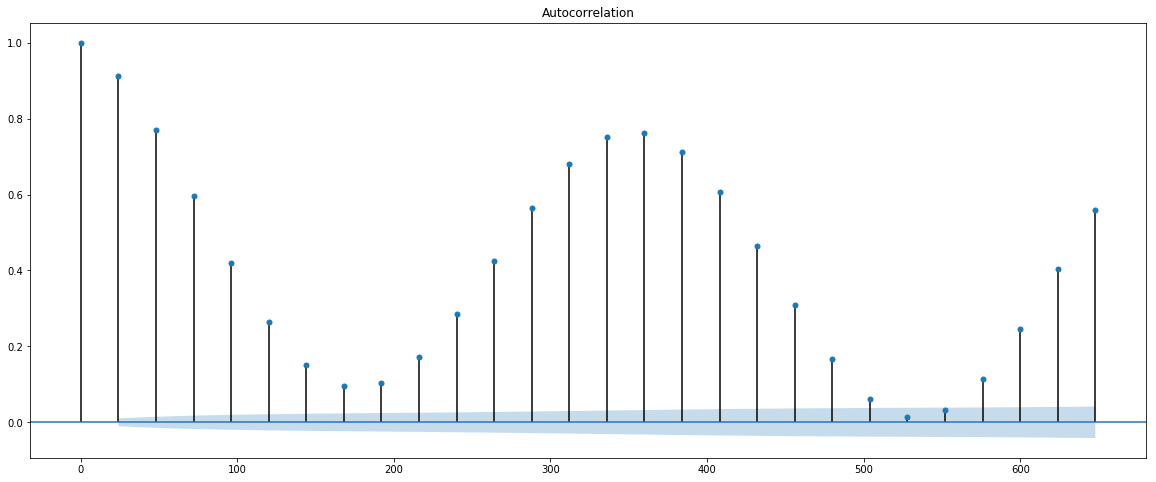

In [37]:
# А теперь посмотрим уровень воды в полночь в течение месяца
# Видно, что как раз пока луна проходит круг вокруг земли в полночь, он чуть смешается
# И в это время, идут приливы и отливы (Важно не путать это с дневным циклом и понимать,
# что на граффике именно цикл в течение месяца в одно и то же время)
fig, ax = plt.subplots(figsize=(20,8))
lags = range(24 * 28)[::24]
sm.graphics.tsa.plot_acf(data.level.values, lags=lags, ax = ax) # 1 лунный месяц
plt.show()

# Теперь попробуем что-нибудь пресказать

In [127]:
# Обучаемся на последнем году, а выводить будем (для наглядности) последние 10 дней
%%time
fit_trend = Holt(np.asarray(test.level[:-24*3])).fit(smoothing_level = 0.25, smoothing_slope = 0.1)

CPU times: user 930 ms, sys: 13.6 ms, total: 944 ms
Wall time: 552 ms


24.117594974557377


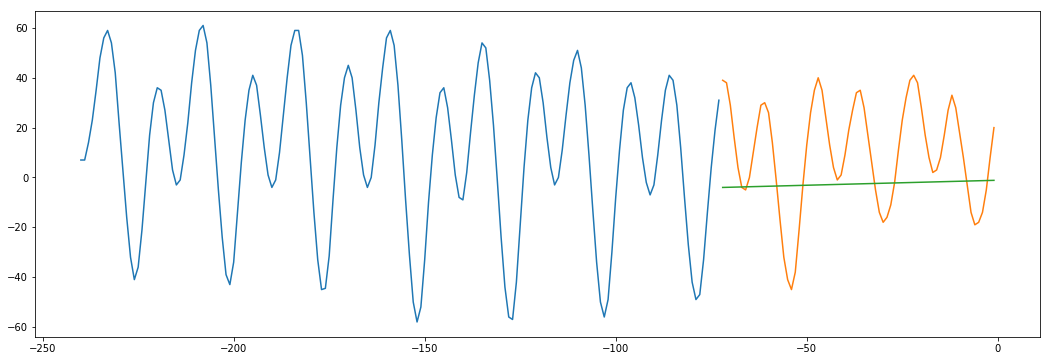

In [137]:
# test - это я где-то вначале выделил, в самом начале - это Последний год(2015)
# Называется тест, потому что когда-то я был наивным и думал, что смогу предсказать на год вперед
plt.figure(figsize=(18, 6))
plt.plot(range(-24*10, -24*3), np.asarray(test[-24*10:-24*3].level))
plt.plot(range(-24*3, 0), np.asarray(data[-24*3:].level))
plt.plot(range(-24*3, 0), fit_trend.forecast(24*3))

print(sqrt(mean_squared_error(test[-24*3:].level, fit_trend.forecast(24*3))))

In [129]:
# Все то же, но для другого метода
%%time
fit_seasonal = ExponentialSmoothing(np.asarray(test.level[:-24*3]), seasonal_periods=24, seasonal='add').fit()

CPU times: user 2min 4s, sys: 1.32 s, total: 2min 6s
Wall time: 1min 3s


17.379046816030055


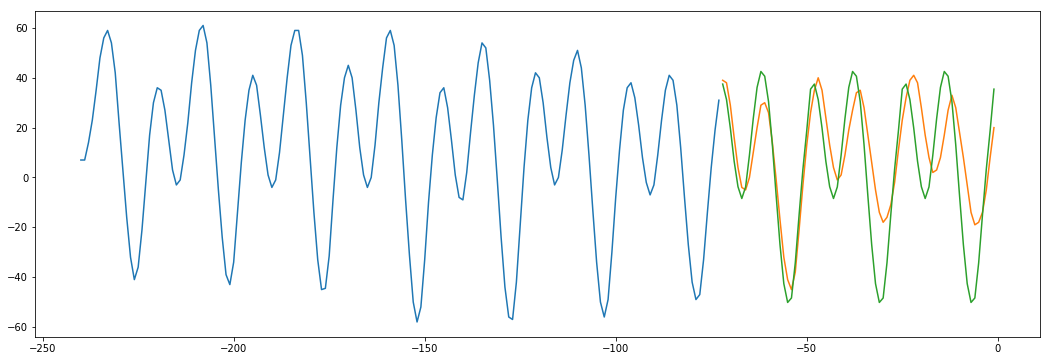

In [138]:
# В конце началось расхождение, видмио, потому что период не ровно 24 часа
plt.figure(figsize=(18, 6))
plt.plot(range(-24*10, -24*3), np.asarray(test[-24*10:-24*3].level))
plt.plot(range(-24*3, 0), np.asarray(data[-24*3:].level))
plt.plot(range(-24*3, 0), fit_seasonal.forecast(24*3))
print(sqrt(mean_squared_error(test[-24*3:].level, fit_seasonal.forecast(24*3))))

In [142]:
# Делать предсказания на более длительные периоды можно было бы,
# Но, кажется, пока что для меня это слишком сложно, опять же,
# Из-за того, что возникает периодичность по месяцам и годам :с

In [143]:
# Оставлю место для ARIMA на случай если мне захочется пожестче

# Немного статистики и критериев

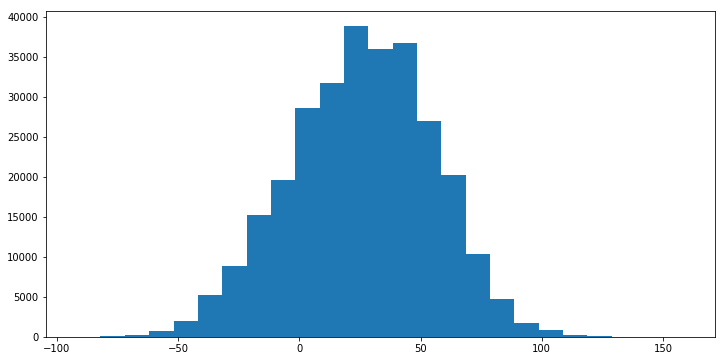

In [211]:
# Ну самое просто, что можо сделать, это вообще посмотреть как распределены уровни воды
# И, что не удивительно, оно нормальное с:
rcParams['figure.figsize'] = 12, 6
plt.hist(data.level, 25)
plt.show()

Same shapes? : True


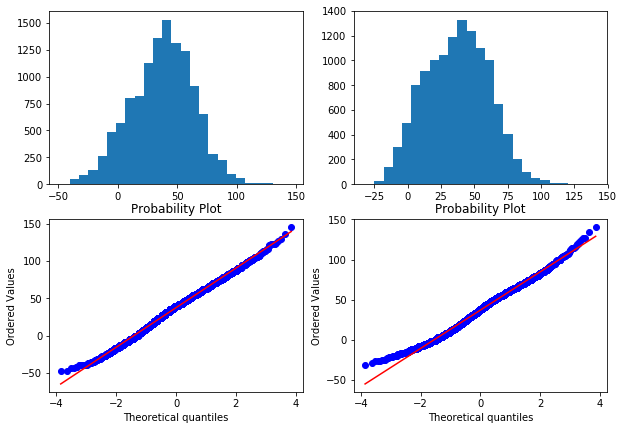

In [255]:
# Гепотеза: Высота приливов в полночь не отличается от высоты приливов в полдень
# Физика приливов говорит нам, что это правда, но давайте это проверим
rcParams['figure.figsize'] = 10, 7
data_midday = data[11::24]
data_midnignt = data[23::24]
print('Same shapes? :', data_midday.shape == data_midnignt.shape)

ax1 = plt.subplot(221)
ax1.hist(data_midday.level, 25)
ax2 = plt.subplot(222)
ax2.hist(data_midnignt.level, 25)

ax3 = plt.subplot(223)
stats.probplot(data_midday.level, dist = "norm", plot = plt)
ax4 = plt.subplot(224)
stats.probplot(data_midnignt.level, dist = "norm", plot = plt)

plt.show()
# Смотря на эти распределения думаю, что гепотеза подтвердится, но надо проверить
# Нижние граффики показывают, что распределения нормальные

In [252]:
# Проверим с помощью T-критерия Стьюдента
# pvalue = 0.22 > 0.05, значит гепотеза не опровергается
# Значит, высота приливов (что логично) не зависит от времени дня
stats.ttest_ind(data_midday.level, data_midnignt.level)

Ttest_indResult(statistic=1.2077951953449428, pvalue=0.2271379003558453)